In [21]:
from typing import Optional
import json
import os
import random

class StockDataHandler:
    """
    A simplified handler for navigating through stock data organized as stockticker -> year -> month -> features.
    This version does only what's necessary for interacting with the stock data and has no unnecessary methods or prints.
    """
    def __init__(self, json_file_path: str):
        """
        Initialize the StockDataHandler by loading data from the provided JSON file.
        """
        if not os.path.exists(json_file_path):
            raise FileNotFoundError(f"The file '{json_file_path}' does not exist.")

        with open(json_file_path, 'r') as file:
            try:
                self.data = json.load(file)
            except json.JSONDecodeError as e:
                raise ValueError(f"Error decoding JSON: {e}")

        if not isinstance(self.data, dict):
            raise ValueError("JSON data must be a dictionary at the top level.")

        self.stock_tickers = sorted(self.data.keys())
        self.current_stock = None
        self.current_year = None
        self.current_month = None
        self.sorted_years = []
        self.sorted_months = []

    def get_stock(self, ticker: Optional[str] = None, year: Optional[str] = None, month: Optional[str] = None) -> dict:
        """
        Retrieve features for a specified stock ticker, year, and month.
        If ticker is None, a random ticker is selected.
        """
        if ticker is None:
            ticker = random.choice(self.stock_tickers)
        self.current_stock = ticker.upper()
        self.sorted_years = sorted(self.data[self.current_stock].keys(), key=lambda y: int(y))

        if year is None:
            year = self.sorted_years[0]
        self.current_year = year

        self.sorted_months = sorted(self.data[self.current_stock][self.current_year].keys(), key=lambda m: int(m))
        if month is None:
            month = self.sorted_months[0]
        self.current_month = month

        return self.data[self.current_stock][self.current_year][self.current_month]

    def step(self) -> dict:
        """
        Move to the next month's features based on the current state.
        :return: A dictionary of features for the next month.
        """
        current_month_idx = self.sorted_months.index(self.current_month)
        if current_month_idx + 1 < len(self.sorted_months):
            self.current_month = self.sorted_months[current_month_idx + 1]
        else:
            current_year_idx = self.sorted_years.index(self.current_year)
            if current_year_idx + 1 < len(self.sorted_years):
                self.current_year = self.sorted_years[current_year_idx + 1]
                self.sorted_months = sorted(self.data[self.current_stock][self.current_year].keys(), key=lambda m: int(m))
                self.current_month = self.sorted_months[0]
            else:
                raise StopIteration("No more data available to step through.")
        
        return self.data[self.current_stock][self.current_year][self.current_month]


In [22]:
import gym
from gym import spaces
import numpy as np
import random
import json
import os
import matplotlib.pyplot as plt

class StockEnv(gym.Env):
    """
    A custom RL environment for interacting with stock data.
    Handles stock data retrieval, stepping through months, and managing random stocks.
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, json_file_path: str, discount_factor=0.1):
        super(StockEnv, self).__init__()

        # Load stock data from the provided JSON file
        if not os.path.exists(json_file_path):
            raise FileNotFoundError(f"The file '{json_file_path}' does not exist.")
        with open(json_file_path, 'r') as file:
            try:
                self.data = json.load(file)
            except json.JSONDecodeError as e:
                raise ValueError(f"Error decoding JSON: {e}")
        
        if not isinstance(self.data, dict):
            raise ValueError("JSON data must be a dictionary at the top level.")

        self.stock_tickers = sorted(self.data.keys())
        self.current_stock = None
        self.current_year = None
        self.current_month = None
        self.sorted_years = []
        self.sorted_months = []
        self.previous_prc = None
        self.current_features = None
        self.current_info = None
        self.current_step = 0
        self.horizon = 12
        self.discount_factor = discount_factor  # Set the discount factor for rewards

        # Dynamically get the size of the feature vector from a sample stock data
        sample_stock = self.get_random_stock()
        feature_vector_size = len(sample_stock)  # Dynamically determine the number of features

        # Observation space: Feature vector (assuming it has a dynamic number of features)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(feature_vector_size,), dtype=np.float32)

        # Action space: Continuous actions between -1 (strong sell) and 1 (strong buy)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

        self.reward_history = []  # To store immediate rewards during the episode
        self.action_history = []  # To store actions during the episode

    def set_horizon(self, horizon: int):
        """
        Set the maximum number of steps (horizon) allowed before resetting.
        """
        self.horizon = horizon

    def get_stock(self, ticker: Optional[str] = None, year: Optional[str] = None, month: Optional[str] = None) -> dict:
        """
        Retrieve features for a specified stock ticker, year, and month.
        If ticker is None, a random ticker is selected.
        """
        if ticker is None:
            ticker = random.choice(self.stock_tickers)
        self.current_stock = ticker.upper()
        self.sorted_years = sorted(self.data[self.current_stock].keys(), key=lambda y: int(y))

        if year is None:
            year = self.sorted_years[0]
        self.current_year = year

        self.sorted_months = sorted(self.data[self.current_stock][self.current_year].keys(), key=lambda m: int(m))
        if month is None:
            month = self.sorted_months[0]
        self.current_month = month

        return self.data[self.current_stock][self.current_year][self.current_month]

    def get_random_stock(self) -> dict:
        """
        Retrieve a random stock ticker with default first year and month.
        """
        return self.get_stock()

    def step(self, action):
        """
        The agent takes a step in the environment. The reward is calculated as the percentage growth of stock price (prc),
        adjusted by the action taken (buy, sell, hold).
        """
        self.current_step += 1

        # Get the current price (prc) from the feature vector
        current_prc = self.current_features['prc']

        # Try to move to the next month
        try:
            self.current_features = self._step_stock()
            self.current_info = {
                'stock_ticker': self.current_stock,
                'date': f"{self.current_year}-{self.current_month}"
            }
        except StopIteration:
            # If monthly data is missing, set done to True
            done = True
            reward = 0  # No reward when done
            return np.array(list(self.current_features.values())), reward, done, self.current_info

        # Calculate the percentage change in price
        next_prc = self.current_features['prc']
        price_change = ((next_prc - current_prc) / current_prc) * 100

        # Immediate reward based on the action and the price change
        # action is between -1 (strong sell) and 1 (strong buy)
        reward = action[0] * price_change  # Action-weighted reward

        # Store the immediate reward and action for future discounting and rendering
        self.reward_history.append(reward)
        self.action_history.append(action[0])

        # Check if horizon is reached or if the data for the next month is missing
        done = self.current_step >= self.horizon or not self._has_next_month()

        return np.array(list(self.current_features.values())), reward, done, self.current_info

    def _step_stock(self) -> dict:
        """
        Move to the next month's features based on the current state.
        :return: A dictionary of features for the next month.
        """
        current_month_idx = self.sorted_months.index(self.current_month)
        if current_month_idx + 1 < len(self.sorted_months):
            self.current_month = self.sorted_months[current_month_idx + 1]
        else:
            current_year_idx = self.sorted_years.index(self.current_year)
            if current_year_idx + 1 < len(self.sorted_years):
                self.current_year = self.sorted_years[current_year_idx + 1]
                self.sorted_months = sorted(self.data[self.current_stock][self.current_year].keys(), key=lambda m: int(m))
                self.current_month = self.sorted_months[0]
            else:
                raise StopIteration("No more data available to step through.")
        
        return self.data[self.current_stock][self.current_year][self.current_month]

    def _has_next_month(self) -> bool:
        """
        Check if there is data available for the next month.
        :return: True if next month data exists, False otherwise.
        """
        current_month_idx = self.sorted_months.index(self.current_month)
        if current_month_idx + 1 < len(self.sorted_months):
            return True
        else:
            current_year_idx = self.sorted_years.index(self.current_year)
            if current_year_idx + 1 < len(self.sorted_years):
                return True
            else:
                return False

    def calculate_discounted_rewards(self):
        """
        Calculate discounted rewards for the entire episode.
        """
        discounted_rewards = np.zeros_like(self.reward_history)
        cumulative_reward = 0
        for t in reversed(range(len(self.reward_history))):
            cumulative_reward = self.reward_history[t] + self.discount_factor * cumulative_reward
            discounted_rewards[t] = cumulative_reward
        return discounted_rewards

    def reset(self):
        """
        Resets the environment to the initial state.
        Picks a random stock and date.
        """
        self.current_step = 0
        self.previous_prc = None  # Reset previous price
        self.reward_history = []  # Clear reward history
        self.action_history = []  # Clear action history

        # Reset stock
        self.current_features = self.get_random_stock()
        self.current_info = {
            'stock_ticker': self.current_stock,
            'date': f"{self.current_year}-{self.current_month}"
        }

        return np.array(list(self.current_features.values()))

    def render(self, mode='human'):
        """
        Renders the environment's current state.
        Displays the stock ticker, date, key features, and action visualization (arrows for buy/sell).
        """
        action = self.action_history[-1] if self.action_history else 0
        if action > 0:
            action_visual = "↑ (Buy)"
        elif action < 0:
            action_visual = "↓ (Sell)"
        else:
            action_visual = "– (Hold)"

        print(f"--- Current Environment State ---")
        print(f"Stock Ticker: {self.current_info['stock_ticker']}")
        print(f"Date: {self.current_info['date']}")
        print(f"Price: {self.current_features['prc']}")
        print(f"Action Taken: {action_visual}")
        print(f"Other Features: {self.current_features}")
        print(f"Step: {self.current_step} / {self.horizon}")
        print("------------------------------")

    def render_with_arrows(self, rewards, discounted_rewards, actions, steps):
        """
        Renders the reward graph with arrows indicating buy, sell, or hold actions at each step,
        also shows discounted rewards.
        """
        plt.plot(steps, rewards, label="Immediate Rewards")
        plt.plot(steps, discounted_rewards, label="Discounted Rewards", linestyle='--')

        # Add arrows for buy, sell, and hold actions
        for i, (step, action) in enumerate(zip(steps, actions)):
            if action > 0:  # Buy action
                plt.annotate('↑', xy=(step, rewards[i]), textcoords="offset points", xytext=(0, 10),
                             ha='center', color='green', fontsize=12)
            elif action < 0:  # Sell action
                plt.annotate('↓', xy=(step, rewards[i]), textcoords="offset points", xytext=(0, -10),
                             ha='center', color='red', fontsize=12)
            else:  # Hold action
                plt.annotate('–', xy=(step, rewards[i]), textcoords="offset points", xytext=(0, 10),
                             ha='center', color='blue', fontsize=12)

        plt.xlabel("Step")
        plt.ylabel("Reward")
        plt.title(f"Immediate and Discounted Rewards with Action Arrows")
        plt.legend()
        plt.grid(True)
        plt.show()

    def close(self):
        """
        Closes the environment (Optional for now).
        """
        pass


Step 1 - Immediate Reward: -3.374647517941698 - Stock Ticker: NEOG - Date: 2018-4
Step 2 - Immediate Reward: 0.0035982564718649956 - Stock Ticker: NEOG - Date: 2018-5
Step 3 - Immediate Reward: 7.344226014640329 - Stock Ticker: NEOG - Date: 2018-6
Step 4 - Immediate Reward: 4.1615520981369665 - Stock Ticker: NEOG - Date: 2018-7
Step 5 - Immediate Reward: 1.97889015885461 - Stock Ticker: NEOG - Date: 2018-8
Step 6 - Immediate Reward: -10.482608870318776 - Stock Ticker: NEOG - Date: 2018-9
Step 7 - Immediate Reward: -0.05673691624350158 - Stock Ticker: NEOG - Date: 2018-10
Step 8 - Immediate Reward: -6.154245874921659 - Stock Ticker: NEOG - Date: 2018-11
Step 9 - Immediate Reward: -2.9103031750855086 - Stock Ticker: NEOG - Date: 2018-12
Step 10 - Immediate Reward: 3.4433562434263236 - Stock Ticker: NEOG - Date: 2019-1
Step 11 - Immediate Reward: -1.3475466028892675 - Stock Ticker: NEOG - Date: 2019-2
Step 1 - Immediate Reward: -3.374647517941698, Discounted Reward: -2.642673237505966
Ste

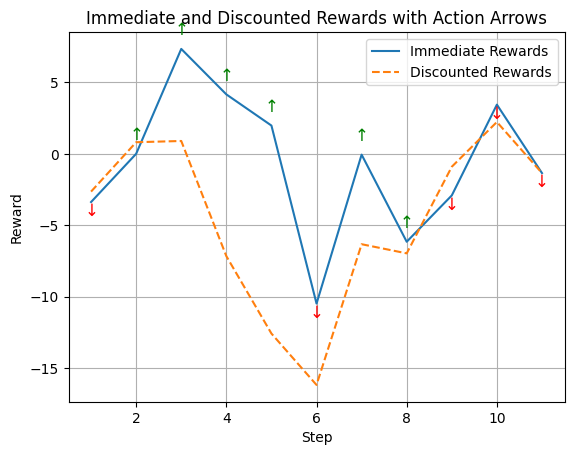

--- Current Environment State ---
Stock Ticker: NEOG
Date: 2019-2
Price: 60.909999847
Action Taken: ↓ (Sell)
Other Features: {'ret_eom': 20190228, 'permno': 75976, 'shrcd': 11, 'exchcd': 3, 'mspread': 0.00554924, 'size_port': 'B', 'rf': 0.0018, 'stock_exret': 0.0154385368, 'cusip': '64049110', 'comp_name': 'NEOGEN CORP', 'eps_medest': 0.14, 'eps_meanest': 0.14, 'eps_stdevest': 0.0, 'eps_actual': 0.125, 'prc': 60.909999847, 'market_equity': 3172.3146121, 'div12m_me': 0.0, 'chcsho_12m': -0.241848143, 'eqnpo_12m': 0.2768715766, 'ret_1_0': 0.0685964897, 'ret_3_1': -0.061264841, 'ret_6_1': -0.30825244, 'ret_9_1': -0.163609703, 'ret_12_1': -0.034389272, 'ret_12_7': 0.3584618708, 'ret_60_12': 0.8730294098, 'seas_1_1an': -0.012874781, 'seas_1_1na': 0.0116905502, 'seas_2_5an': 0.0166156041, 'seas_2_5na': 0.0164764659, 'at_gr1': 0.1709961376, 'sale_gr1': 0.0842599111, 'capx_gr1': 0.1866598058, 'inv_gr1': 0.0729843488, 'debt_gr3': nan, 'sale_gr3': 0.3898289906, 'capx_gr3': 0.8580924564, 'inv_gr1a

In [26]:
def main():
    json_file = 'stocks_dict.json'  # Ensure this file exists with the correct format
    env = StockEnv(json_file_path=json_file, discount_factor=0.9)  # Adjust discount factor as needed
    env.set_horizon(12)  # Set a horizon of 12 steps

    rewards = []
    steps = []
    actions = []
    ticker = None
    observation = env.reset()
    done = False

    # Run through all steps until the environment is done
    step_counter = 0
    while not done:
        step_counter += 1
        action = env.action_space.sample()  # Random action between -1 and 1
        observation, reward, done, info = env.step(action)
        rewards.append(reward)  # Store the reward for visualization
        actions.append(action[0])  # Store the action for arrow visualization
        steps.append(step_counter)
        ticker = info.get('stock_ticker', 'Unknown')  # Retrieve the stock ticker
        print(f"Step {step_counter} - Immediate Reward: {reward} - Stock Ticker: {ticker} - Date: {info['date']}")

    # Calculate discounted rewards
    discounted_rewards = env.calculate_discounted_rewards()

    # Print discounted rewards for each step
    for step, (reward, discounted_reward) in enumerate(zip(rewards, discounted_rewards)):
        print(f"Step {step + 1} - Immediate Reward: {reward}, Discounted Reward: {discounted_reward}")

    # Plot the rewards with action arrows and discounted rewards
    env.render_with_arrows(rewards, discounted_rewards, actions, steps)

    # Render the final state
    env.render()

if __name__ == "__main__":
    main()
